In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../../pykliep/

/atlas/u/kechoi/pykliep


# Dataset

In [5]:
import torch
from sklearn.linear_model import LogisticRegression
from pykliep import DensityRatioEstimator

In [6]:
rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/source.npz')
X = rec['x']
y = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target.npz')
Z = rec['x']
u = rec['y']

rec = np.load('/atlas/u/kechoi/multi-fairgen/data/kmm/target_test.npz')
Z_test = rec['x']
u_test = rec['y']

In [7]:
kliep = DensityRatioEstimator()
kliep.fit(X, Z) # keyword arguments are X_train and X_test
weights = kliep.predict(X)

/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))
/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: overflow encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))


In [8]:
weights.shape

(1000,)

In [9]:
# Train via KLIEP
clf = LogisticRegression()
clf.fit(X, y, sample_weight=weights)
pred_adapt = clf.predict(Z)

# Train a naive logistic regressor
lr = LogisticRegression().fit(X, y)

# Make predictions
pred_naive = lr.predict(Z)


# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive != u, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error naive: 0.297
Error adapt: 0.233


In [10]:
pred_adapt_test = clf.predict(Z_test)
pred_naive_test = lr.predict(Z_test)

# Compute error rates
print('Error naive: ' + str(np.mean(pred_naive_test != u_test, axis=0)))
print('Error adapt: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error naive: 0.286
Error adapt: 0.208


What about the flow?

In [11]:
cd ../multi-fairgen/src/

/atlas/u/kechoi/multi-fairgen/src


In [12]:
device = 'cuda'
restore_file = 'flows/results/kmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
print(state['epoch'])

85


In [13]:
from flows.models.maf import MAF

def load_flow():
    model = MAF(5, 
                2, 
                100, 
                1, 
                None, 
                'relu', 
                'sequential', 
                batch_norm=True)
    restore_file = 'flows/results/kmm_flow/'
    state = torch.load(os.path.join(restore_file, "model_checkpoint.pt"), map_location='cuda')
    model.load_state_dict(state['model_state'])
    model = model.to(device)
    return model

flow = load_flow()
flow.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

Text(0.5, 1.0, 'Source + Target')

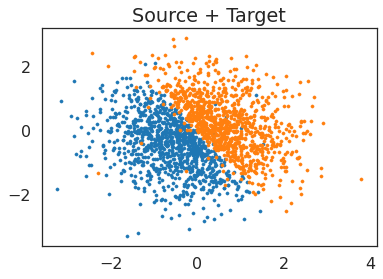

In [14]:
# encode data points
flow_train_x, _ = flow.forward(torch.from_numpy(X).cuda().float())
flow_test_x, _ = flow.forward(torch.from_numpy(Z).cuda().float())

plt.scatter(flow_train_x[:,0].data.cpu().numpy(), flow_train_x[:,1].data.cpu().numpy(), s=10)
plt.scatter(flow_test_x[:,0].data.cpu().numpy(), flow_test_x[:,1].data.cpu().numpy(), s=10)

plt.title('Source + Target')

### train KLIEP on z

In [15]:
flow_x = flow_train_x.data.cpu().numpy()
flow_z = flow_test_x.data.cpu().numpy()

In [16]:
kliep = DensityRatioEstimator()
kliep.fit(flow_x, flow_z) # keyword arguments are X_train and X_test
z_weights = kliep.predict(flow_x)

/atlas/u/kechoi/pykliep/pykliep.py:168: RuntimeWarning: divide by zero encountered in true_divide
  out += epsilon*np.dot(np.transpose(A),1./np.dot(A,out))


In [17]:
# Train via KLIEP
clf = LogisticRegression()
# clf.fit(flow_x, y, sample_weight=z_weights)
# pred_adapt = clf.predict(flow_z)
clf.fit(X, y, sample_weight=z_weights)
pred_adapt = clf.predict(Z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.223


In [18]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
# pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
pred_adapt_test = clf.predict(Z_test)
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.201


Target
- Error naive: 0.297
- Error adapt: 0.233
- Error adapt (z-space): 0.223

Target (test)
- Error naive: 0.286
- Error adapt: 0.208
- Error adapt (z-space): 0.201

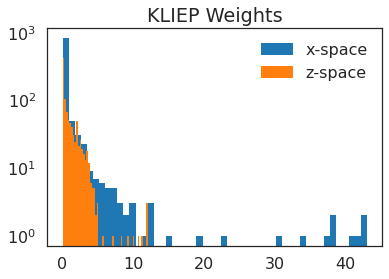

In [19]:
_ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
plt.yscale('log')

plt.title('KLIEP Weights')
plt.legend()

---------

### What if I do the entire thing in z-space?

In [20]:
# Train via KLIEP
clf = LogisticRegression()
clf.fit(flow_x, y, sample_weight=z_weights)
pred_adapt = clf.predict(flow_z)

# Compute error rates
print('Error adapt: ' + str(np.mean(pred_adapt != u, axis=0)))

Error adapt: 0.344


In [21]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_adapt_test = clf.predict(flow_test_real.data.cpu().numpy())
print('Error adapt in z-space: ' + str(np.mean(pred_adapt_test != u_test, axis=0)))

Error adapt in z-space: 0.336


----

### naive LR in z-space

In [27]:
lr = LogisticRegression()
lr.fit(flow_x, y)
pred_naive = lr.predict(flow_z)

# Compute error rates
print('Error naive in z-space: ' + str(np.mean(pred_naive != u, axis=0)))

Error naive in z-space: 0.635


In [28]:
# target test
flow_test_real, _ = flow(torch.from_numpy(Z_test).float().cuda())
pred_naive_test = lr.predict(flow_test_real.data.cpu().numpy())
print('Error naive (test) in z-space: ' + str(np.mean(pred_naive_test != u_test, axis=0)))

Error naive (test) in z-space: 0.629


---

# Weights

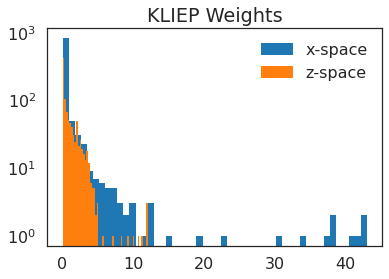

In [36]:
_ = plt.hist(weights, bins=50, label='x-space')
_ = plt.hist(z_weights, bins=50, label='z-space')
plt.yscale('log')

plt.title('KLIEP Weights')
plt.legend()